In [13]:
import torch
from classifier import Classifier
import datasets as datasets
from torch.utils.data import DataLoader
from gan_model import DCGAN_i
import pandas as pd
import matplotlib.pyplot as plt
from refiner import SyntheticDataset, R_Train
import os
import shutil
from tqdm import tqdm_notebook as tqdm
import numpy as np

# Utils

In [2]:
mapping = {
    'preictal_0': 0,
    'interictal': 1,
}

batch_size = 64

chb_path = "/Users/kevin/Desktop/file_all/processed"
# chbmit = datasets.ChbmitFolder("/home/tian/DSI/datasets/CHB-MIT-log", "train", mapping, True)
# chb_dataset = datasets.EEGDataset(chbmit.get_all_data())
# chb_dataloader = DataLoader(chb_dataset, batch_size=1, shuffle=True)
# chb_dataloader = DataLoader(chb_dataset, batch_size=64, shuffle=True)

# dataset_synthetic = SyntheticDataset("/home/tian/DSI/datasets/CHB_synthetic")
# data_loader_synthetic = DataLoader(dataset_synthetic, batch_size=64, shuffle=True)

In [3]:

# TODO update back these three params and pretrain
num_epoch_dcgan = 20
num_epoch_classifier = 20
num_step_refiner = 200
learning_rate = 0.0001
# The channel of eeg
num_channels = 22
# the number of prediction classes
num_classes = 2

def get_classifier():
    return Classifier(num_channels, num_classes=num_classes)

def get_test_metric(classifier, train_loader, test_loader):
    classifier.train(train_loader, num_epoch_classifier, 0.0001)
    # test_auc = classifier.get_test_auc(test_loader)
    test_auc = classifier.get_test_metric(test_loader).roc_auc_score()
    return test_auc

def train_test_patient(chb_path: str, mapping: dict ,patient_name: str, batch_size=64, train_on_real=False):
    # set up
    chb_folder_train = datasets.ChbmitFolder(chb_path, 'train', mapping, 1)
    chb_folder_train_uneven = datasets.ChbmitFolder(chb_path, 'train',mapping, 2)
    chb_folder_test = datasets.ChbmitFolder(chb_path, 'test', mapping, 3)
    patient_dataset_train = datasets.EEGDataset(chb_folder_train.get_patient_data(patient_name))
    patient_dataset_train_uneven = datasets.EEGDataset(chb_folder_train_uneven.get_patient_data(patient_name))
    patient_dataset_test = datasets.EEGDataset(chb_folder_test.get_patient_data(patient_name))
    patient_loader_train = DataLoader(patient_dataset_train, batch_size = batch_size)
    patient_loader_train_uneven = DataLoader(patient_dataset_train_uneven, batch_size=batch_size)
    patient_loader_test = DataLoader(patient_dataset_test, batch_size = batch_size)

    # train the dcgan
    dcgan = DCGAN_i(num_channels, num_classes)
    dcgan.train(patient_loader_train, num_epoch_dcgan, learning_rate)
    dcgan_dataset = datasets.GANDataset(dcgan, len(patient_dataset_train))
    dcgan_loader = DataLoader(dcgan_dataset, batch_size=64, shuffle=True)

    # train refiner
    r_train = R_Train(22,128,32, patient_loader_train_uneven, None, learning_rate, device='cuda', DCGAN = dcgan)
    r_train.train(num_step_refiner, 3,1,0.000001,pretrain=True, pretrain_G=50, pretrain_D=25)
    refiner_dataset = datasets.GANDataset(r_train, len(patient_dataset_train))
    refiner_loader = DataLoader(refiner_dataset, batch_size=64, shuffle=True)

    # real data
    classifier = get_classifier()
    r_auc = 0
    if train_on_real:
        r_auc= get_test_metric(classifier, patient_loader_train, patient_loader_test)
    real_state_dict = classifier.model.state_dict()
    s_auc = get_test_metric(classifier, dcgan_loader, patient_loader_test)
    # reset the classifier to the previous state
    classifier.model.load_state_dict(real_state_dict)
    refine_auc = get_test_metric(classifier, refiner_loader, patient_loader_test)

    metric = [patient_name, r_auc, s_auc,  refine_auc]

    dcgan.G.to('cpu')
    dcgan.D.to('cpu')
    r_train.G.to('cpu')
    r_train.D.to('cpu')
    classifier.model.to('cpu')
    models = [dcgan, r_train, classifier]
    return metric, models

In [4]:
def patient_specific_test(chb_path, mapping):
    patient_names = os.listdir(chb_path)
    patient_names.sort()
    acc_metrics, acc_models = [], []
    num_fail = 0
    for i, patient in enumerate(patient_names):
        # try:
            metrics, models = train_test_patient(chb_path, mapping, patient)
            acc_metrics.append(metrics)
            acc_models.append(models)
            print(f"currently processing patient {patient}, {i+1}/{len(patient_names)}, {metrics[1:]}")
        # except:
        #     num_fail += 1
        #     print(f"patient {patient} fail!!!, failure {num_fail}")
        # break
    return acc_metrics, acc_models



In [5]:
patient_specific_metricsv吧, patient_specific_models = patient_specific_test(chb_path, mapping)


currently processing patient chb01, 1/22, [0, 0.533211932015262, 0.47233784252514743]


currently processing patient chb02, 2/22, [0, 0.42333333333333334, 0.43416666666666665]


R_Discriminator Pretraining:   8%|██████████                                                                                                                    | 2/25 [00:00<00:10,  2.23it/s, D Cross Entropy Loss 1.4004907608032227][W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


currently processing patient chb03, 3/22, [0, 0.5966666666666667, 0.6633333333333333]


currently processing patient chb04, 4/22, [0, 0.6265943877551021, 0.6293579931972789]


currently processing patient chb05, 5/22, [0, 0.34608047173083595, 0.36073534512660427]


currently processing patient chb06, 6/22, [0, 0.35392128698649816, 0.36601072488748443]


currently processing patient chb07, 7/22, [0, 0.3687352492017215, 0.3706788837984173]


currently processing patient chb08, 8/22, [0, 0.45558176100628933, 0.45951257861635225]


currently processing patient chb09, 9/22, [0, 0.5923148148148147, 0.5864814814814814]


currently processing patient chb10, 10/22, [0, 0.30248119212962965, 0.29716435185185186]


currently processing patient chb11, 11/22, [0, 0.7120181405895691, 0.6617535903250188]


currently processing patient chb13, 12/22, [0, 0.7416173570019724, 0.9013806706114398]


currently processing patient chb14, 13/22, [0, 0.3739035087719298, 0.37950779727095524]


currently processing patient chb15, 14/22, [0, 0.14429741650913674, 0.13295526149968495]


currently processing patient chb16, 15/22, [0, 0.5844907407407407, 0.6041666666666667]


currently processing patient chb17, 16/22, [0, 0.4764169639318272, 0.4740388426476417]


currently processing patient chb18, 17/22, [0, 0.5404383975812548, 0.5761526832955404]


currently processing patient chb19, 18/22, [0, 0.6126415671870218, 0.6978879706152434]


currently processing patient chb20, 19/22, [0, 0.09911242603550297, 0.04930966469428007]


currently processing patient chb21, 20/22, [0, 0.7308333333333333, 0.7875]


currently processing patient chb22, 21/22, [0, 0.30436213991769545, 0.29843621399176956]


currently processing patient chb23, 22/22, [0, 0.6016666666666668, 0.5941666666666666]


In [8]:
df_result = pd.DataFrame(patient_specific_metrics, columns = ['patient name', '_', "synthetic auc", 'refine auc'])
df_result

,patient name,_,synthetic auc,refine auc
0,chb01,0,0.533212,0.472338
1,chb02,0,0.423333,0.434167
2,chb03,0,0.596667,0.663333
3,chb04,0,0.626594,0.629358
4,chb05,0,0.346080,0.360735
5,chb06,0,0.353921,0.366011
6,chb07,0,0.368735,0.370679
7,chb08,0,0.455582,0.459513
8,chb09,0,0.592315,0.586481
9,chb10,0,0.302481,0.297164


In [14]:
np.mean(df_result['refine auc'])

0.4907743286258874

In [49]:
df_tmp = df_result.set_index('patient name')

In [52]:
df_round = df_tmp.round(decimals=1)

/Users/kevin/Desktop/venv/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_' of <BarContainer object of 22 artists> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)


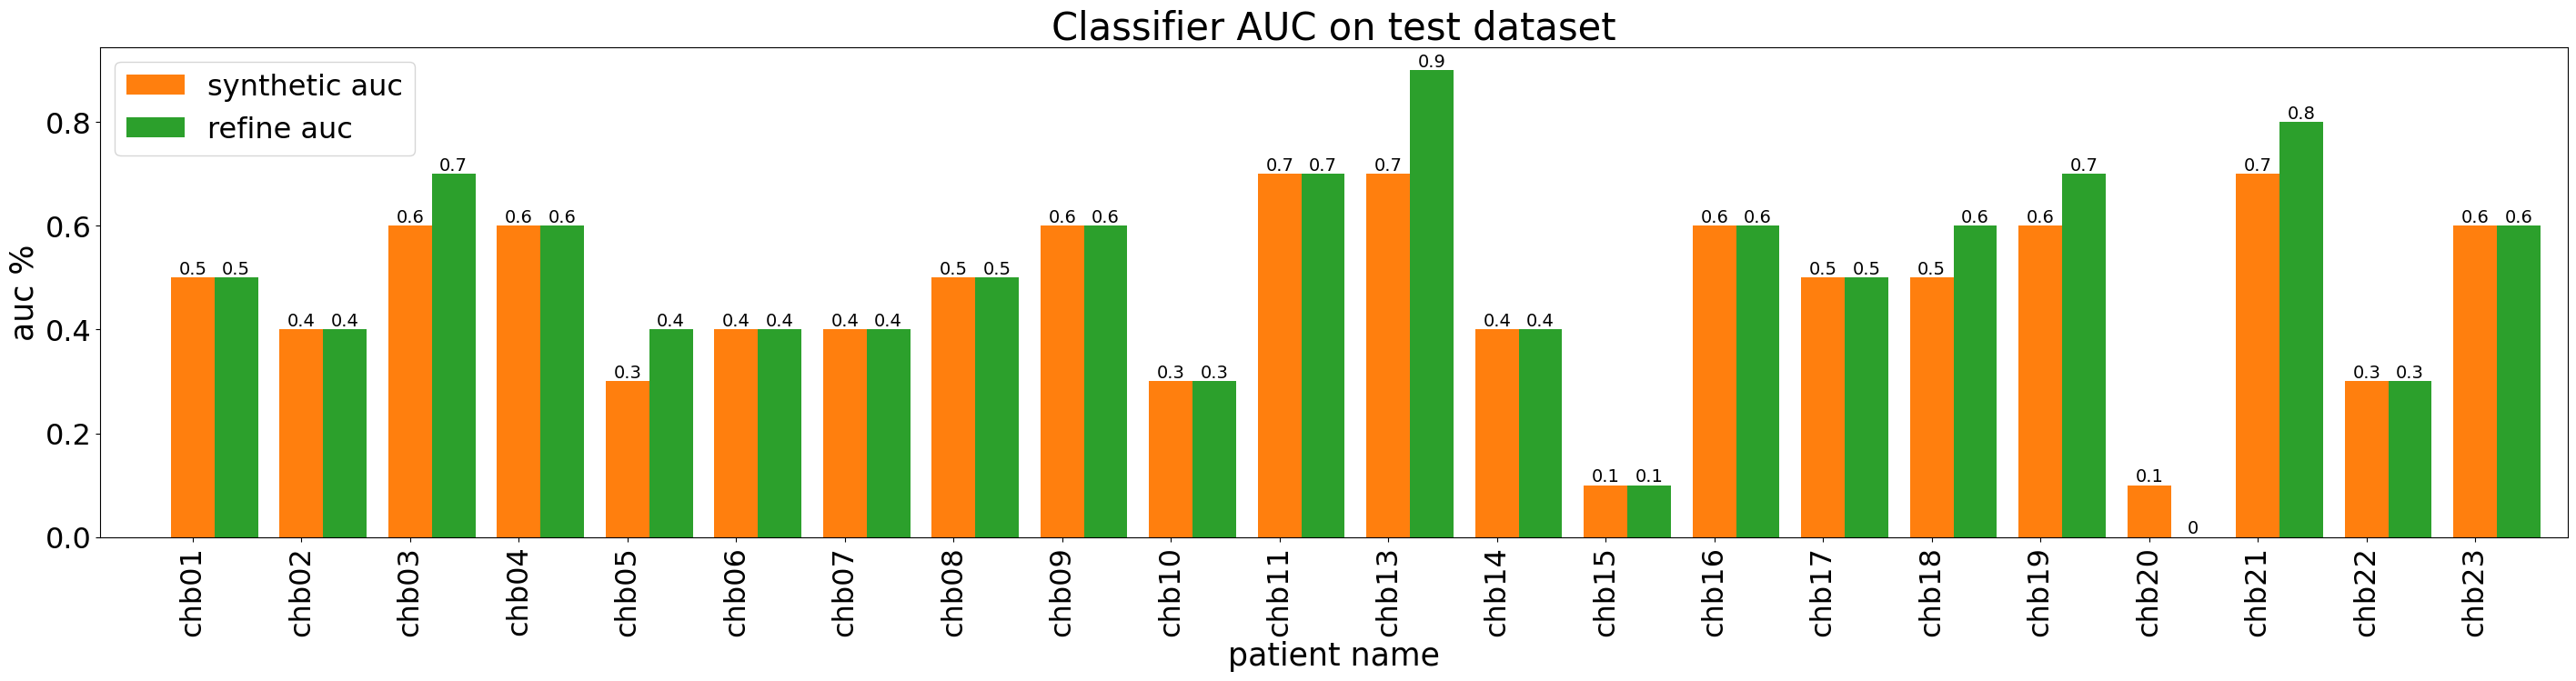

In [53]:
ax = df_round.plot.bar(figsize=(35, 7), fontsize=23, width=1.2)
for i, container in enumerate(ax.containers):
    if i %3==0: continue
    ax.bar_label(container, fontsize=14)
plt.title('Classifier AUC on test dataset', fontsize=30)
plt.ylabel('auc %', fontsize=25)
plt.xlabel('patient name', fontsize=25)
plt.legend(prop={'size':23})
plt.show()

In [54]:
df_tmp2 = df_tmp[(df_tmp['synthetic auc'] > 34) ]
df_tmp3 = df_tmp2[df_tmp2['synthetic auc'] < 90]
value = np.mean(df_tmp3['refine auc'])


In [55]:
value

nan

In [56]:
best_pair = (-1,-1,-1)
for large in range(100, 30, -1):
    for small in range(30, large):
        df_tmp2 = df_tmp[(df_tmp['synthetic auc'] > small) ]
        df_tmp3 = df_tmp2[df_tmp2['synthetic auc'] < large]
        value = np.mean(df_tmp3['refine auc'] - df_tmp3['synthetic auc'])
        if value > best_pair[0] and value < 20:
            print(best_pair, len(df_tmp3))
            best_pair = (value, small, large)

In [57]:
best_pair

(-1, -1, -1)

In [58]:
df_tmp3

,_,synthetic auc,refine auc
patient name,,,


In [59]:
np.mean(df_tmp3['refine auc'] - df_tmp3['synthetic auc'])

nan

In [60]:
df_tmp2

,_,synthetic auc,refine auc
patient name,,,


In [61]:
len(df_tmp)

22

In [62]:
import numpy as np
synthetic_auc = np.array(list(df_tmp['synthetic auc']))
refine_auc = np.array(list(df_tmp['refine auc']))
np.mean(refine_auc - synthetic_auc)

0.012559794357396386

In [63]:
df_result.to_csv("result_syn_refine.csv")

In [64]:
import os
def save_trained_models(metrics, models):
    for i,  (dcgan, rtrain, classifier) in enumerate(models):
        patient_name = metrics[i][0]
        cur_dir = f'./cache/{patient_name}_ckpt'
        os.makedirs(cur_dir, exist_ok=True)
        torch.save(dcgan.G.state_dict(), os.path.join(cur_dir, 'dcgan_G.ckpt'))
        torch.save(dcgan.D.state_dict(), os.path.join(cur_dir, 'dcgan_D.ckpt'))
        torch.save(rtrain.G.state_dict(), os.path.join(cur_dir, 'rtrain_G.ckpt'))
        torch.save(rtrain.D.state_dict(), os.path.join(cur_dir, 'rtrain_D.ckpt'))
        torch.save(classifier.model.state_dict(), os.path.join(cur_dir, 'classifier.ckpt'))

save_trained_models(patient_specific_metrics, patient_specific_models)



In [65]:
def plot_data(data, title):
    cols = 4
    fig, axs = plt.subplots(nrows=1+(len(data)-1)//4, ncols=4)
    for i in range(len(data)):
        row = i // cols
        col = i % cols
        axs[row,col].set_title(f'channel {i}')
        im = axs[row,col].pcolormesh(range(32), range(128), data[i], cmap=plt.cm.jet)
        fig.colorbar(im, ax=axs[row,col])
    fig.suptitle(title)
    fig.set_size_inches(10,10)
    fig.tight_layout()
    plt.show()

def plot_data_tensor(data, title=""):
    data = data[0].detach().numpy()
    plot_data(data, title)


In [66]:
real_spec = np.load('/Users/kevin/Desktop/file_all/processed/chb05/train/preictal_0/chb05_05.preictal_0.27.npy')
plot_data(real_spec, '')


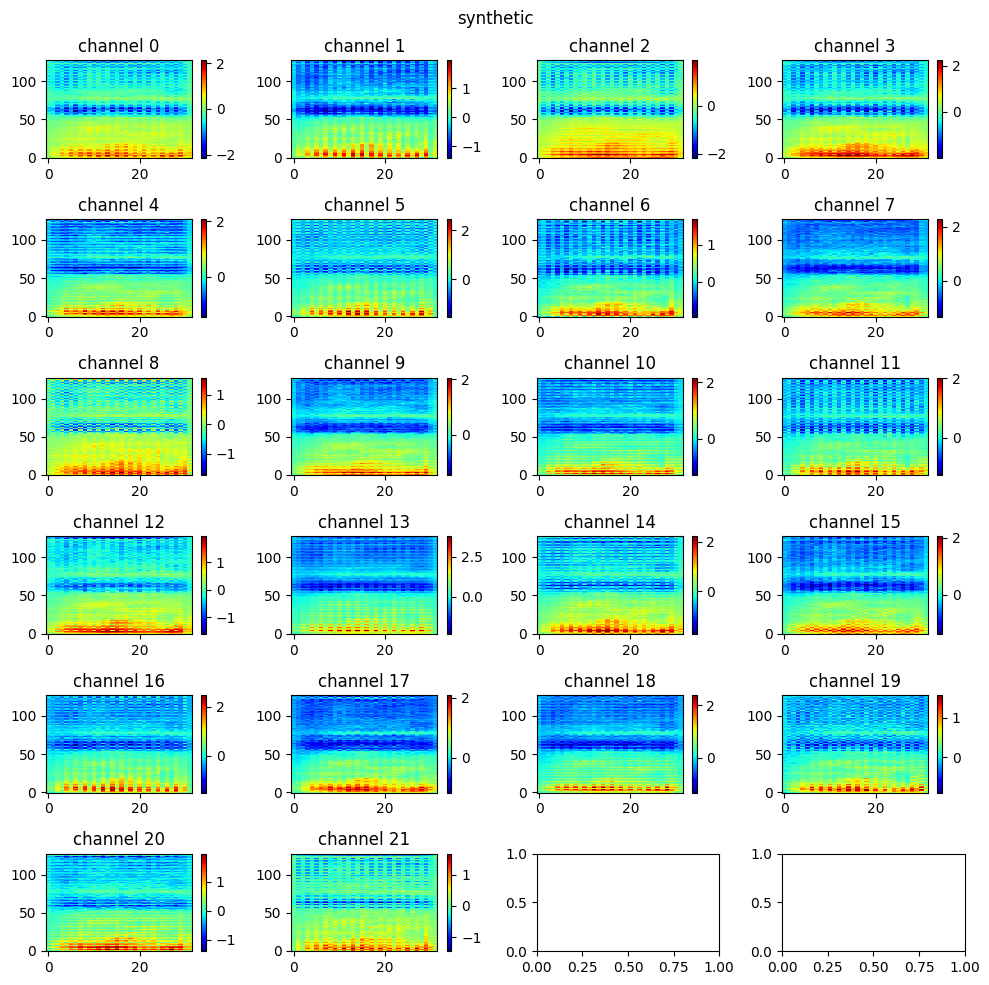

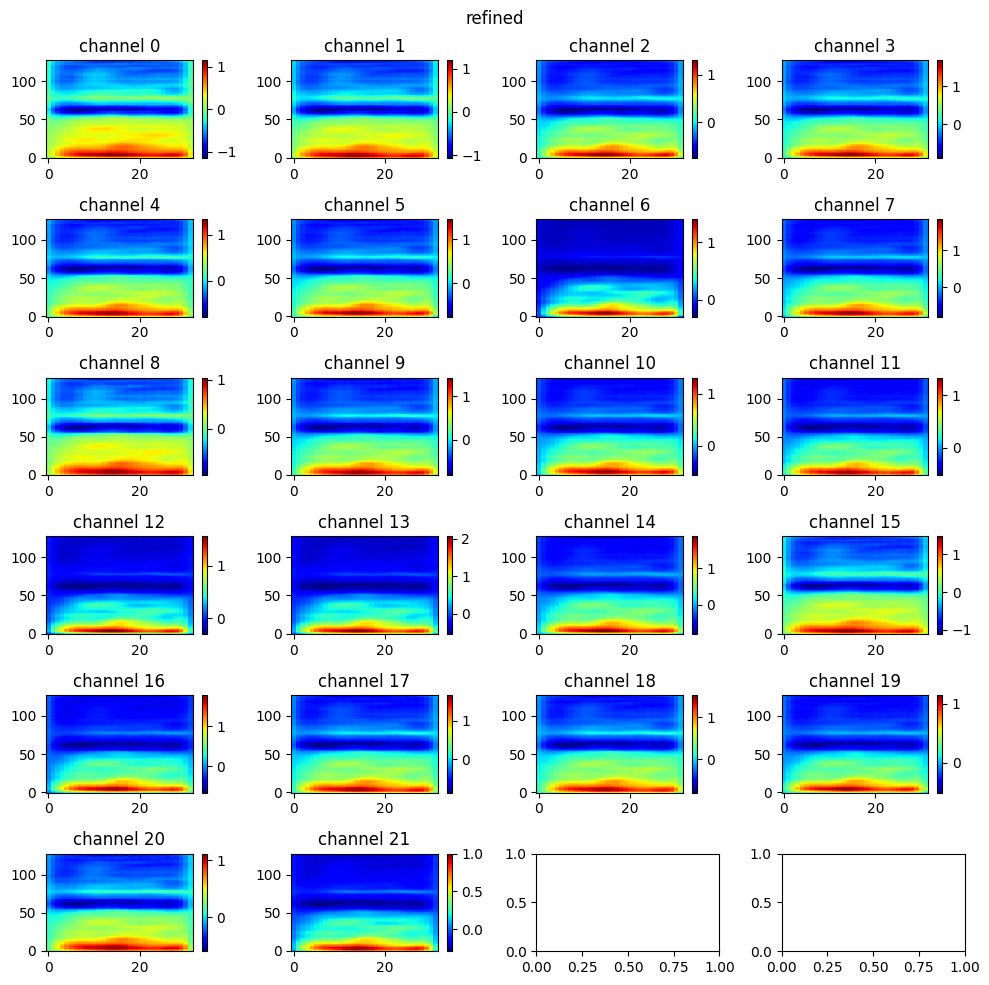

In [67]:
import numpy as np
dcgan, r_train, _ = patient_specific_models[4]
generator_dcgan = dcgan.G
generator_refiner = r_train.G
noise = torch.rand((1,100), device='cpu', dtype=torch.float32)
noise2 =torch.rand((1,100), device='cpu', dtype=torch.float32)
generated_image = generator_dcgan(noise, torch.tensor([0]))
# generated_image2 = generator_dcgan(noise2, torch.tensor([0]))
refined_image = generator_refiner(generated_image)
plot_data_tensor(generated_image, 'synthetic')
plot_data_tensor(refined_image, 'refined')


In [35]:
generated_image = generated_image[0].detach().cpu().numpy()
refined_image = refined_image[0].detach().cpu().numpy()


In [36]:
generated_image.shape

(22, 128, 32)

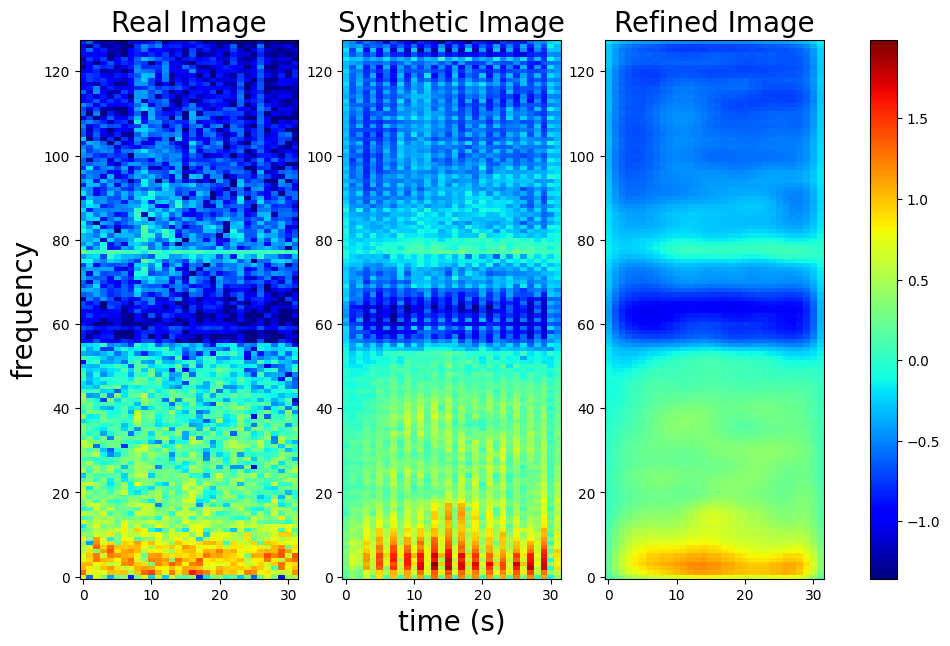

In [37]:
fig, axs = plt.subplots(1, ncols=3, figsize=(12, 7))
axs[0].set_title('Real Image', fontsize=20)
axs[1].set_title('Synthetic Image', fontsize=20)
# axs[0].set_xlabel('time (s)', fontsize=20)
axs[1].set_xlabel('time (s)', fontsize=20)
# axs[2].set_xlabel('time (s)', fontsize=20)
axs[0].set_ylabel('frequency', fontsize=20)
axs[2].set_title('Refined Image', fontsize=20)
im0 = axs[0].pcolormesh(range(32), range(128), real_spec[1], cmap=plt.cm.jet)
im1 = axs[1].pcolormesh(range(32), range(128), generated_image[1], cmap=plt.cm.jet)
im2 = axs[2].pcolormesh(range(32), range(128), refined_image[1], cmap=plt.cm.jet)
cb0 = fig.colorbar(im0, ax=axs[0])
cb1 = fig.colorbar(im1, ax=axs[1])
cb2 = fig.colorbar(im2, ax=axs[2])
cb0.mappable.set_clim(*cb1.mappable.get_clim())

cb2.mappable.set_clim(*cb1.mappable.get_clim())
cb0.remove()
cb1.remove()
cb2.remove()
fig.colorbar(im2, ax=axs.ravel().tolist())

plt.show()

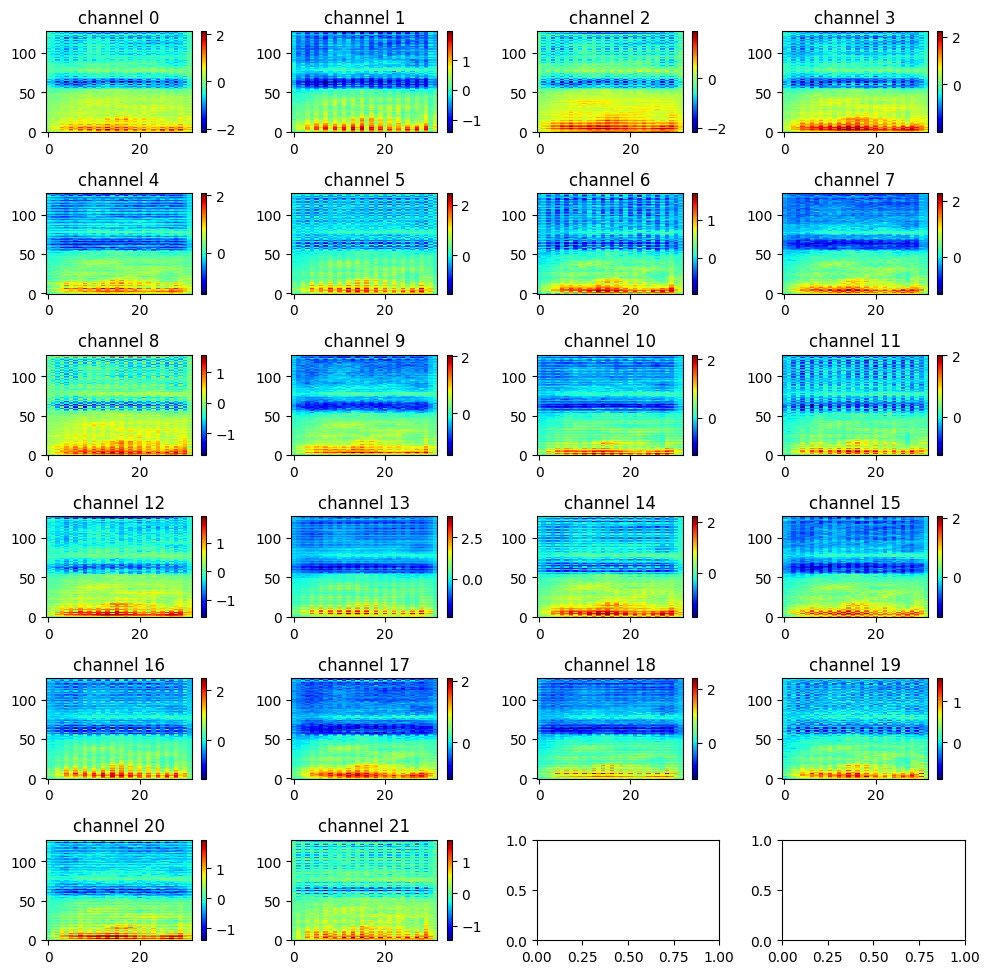

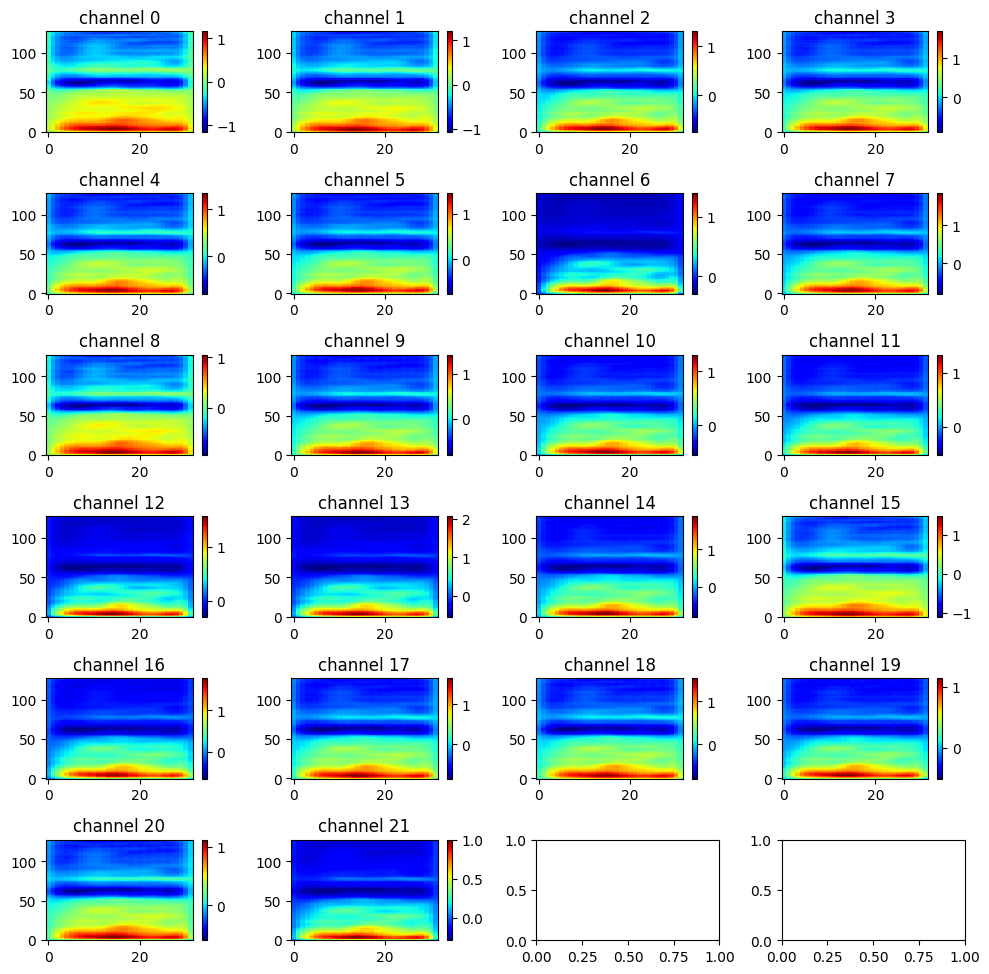

In [68]:
plot_data_tensor(generated_image, '')
plot_data_tensor(refined_image, '')

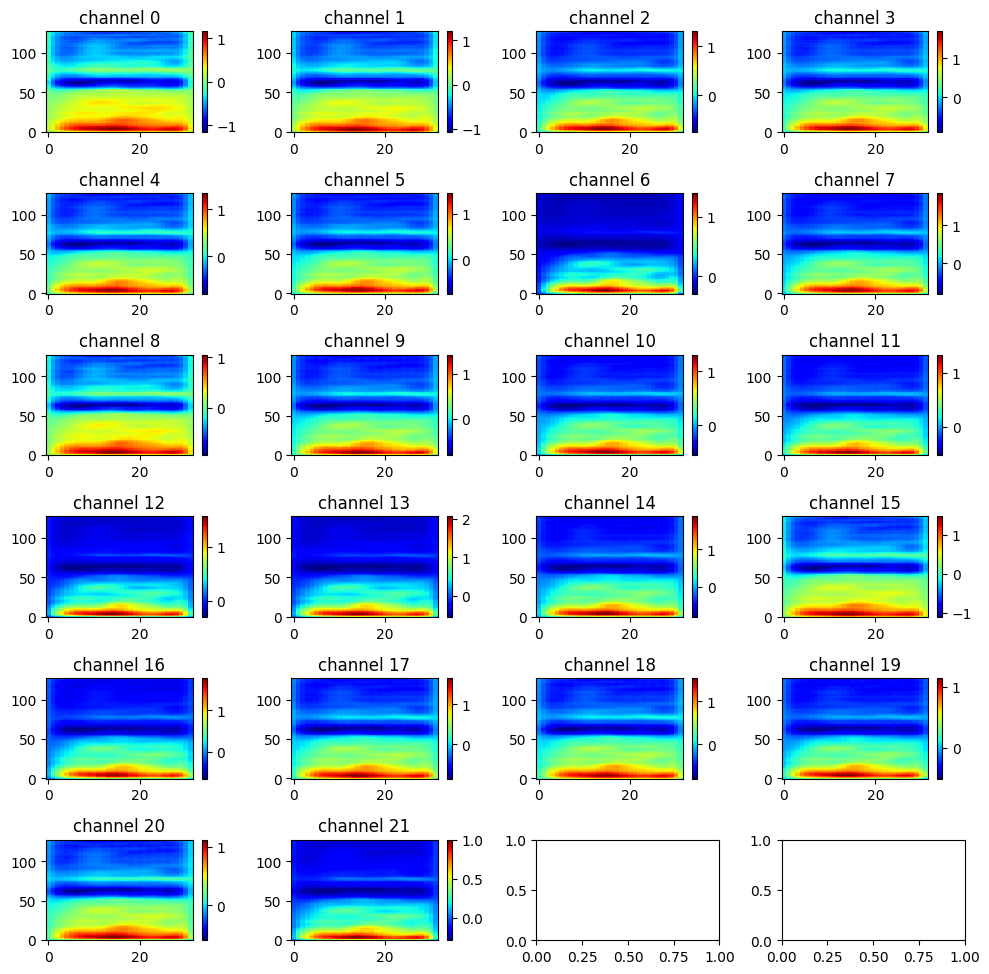

In [69]:
plot_data_tensor(refined_image, '')

In [73]:
plot_data_tensor(generated_image - generated_image2)

NameError: name 'generated_image2' is not defined

In [74]:
d_types = ['train', 'test']
s_types = ['interictal', 'preictal_0']
acc_data = []
for patient in os.listdir(chb_path):
    cur_path = os.path.join(chb_path, patient)
    cur_data = [patient]
    for d_type in d_types:
        for s_type in s_types:
            tmp_path = os.path.join(cur_path, d_type, s_type)
            cur_data.append(len(os.listdir(tmp_path)))
    acc_data.append(cur_data)

data_df = pd.DataFrame(acc_data, columns=['patient name', 'train interictal', 'train preictal 0', 'test interictal', 'test preictal0'])
data_df  = data_df.sort_values(by=['patient name'])


In [75]:
data_df.to_csv('data.csv')

In [76]:
data_df = pd.read_csv('data.csv')

In [77]:
data_df

,Unnamed: 0,patient name,train interictal,train preictal 0,test interictal,test preictal0
0,19,chb01,1457,261,360,62
1,11,chb02,2324,83,573,20
2,8,chb03,2528,43,624,10
3,9,chb04,12107,228,3004,56
4,10,chb05,1390,265,342,62
5,20,chb06,2493,484,618,118
6,18,chb07,4696,203,1164,49
7,21,chb08,199,222,48,53
8,17,chb09,4453,245,1108,60
9,7,chb10,2353,392,580,96


In [78]:
train_interictal = np.array(list(data_df['train interictal']))
train_preict = np.array(list(data_df['train preictal 0']))


In [79]:
np.mean(train_interictal / train_preict)


16.132575051333728